 # Hyperparameter Search for MPF Bagged Model



 In this cell we define helper functions for evaluating one hyperparameter candidate and performing a randomized search in parallel. We then use our random search function on training data.

In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
import numpy as np
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import mpf_py
from utils import gen_data, true_model3, plot_2d_model_predictions  # Adjust import according to your project structure
from scipy.stats import randint

def evaluate_params(x_train, y_train, kf, **params):
    """
    Evaluates one hyperparameter combination using cross-validation.
    Returns a tuple (epochs, B, n_iter, split_try, avg_mse).
    """
    errors = []
    for train_index, val_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_val = x_train[val_index]
        y_val = y_train[val_index]

        # Fit the bagged model on the training split.
        print(params)
        model, fr = mpf_py.MPF.fit_bagged(
            x_tr, y_tr, **params
        )
        # Predict on the validation split.
        y_pred = model.predict(x_val)
        mse = np.mean((y_val - y_pred) ** 2)
        errors.append(mse)
    avg_error = np.mean(errors)
    return avg_error

def random_hyperparam_search_parallel(x_train, y_train, n_splits=2, n_candidates=50, n_jobs=-1, param_distributions=None):
    """
    Performs a random grid search cross-validation over hyperparameters for mpf_py.MPF.fit_bagged.
    
    Parameters:
        x_train, y_train: Training data.
        n_splits: Number of cross-validation splits.
        n_candidates: Number of hyperparameter combinations to evaluate.
        n_jobs: Number of parallel jobs.
        param_distributions: A dictionary specifying the hyperparameter distributions.
                           Each key is a hyperparameter name, and each value is a distribution
                           (e.g., scipy.stats.randint, scipy.stats.uniform).
    
    Returns the best model, additional fitted result (fr), best parameters, and best error.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Default parameter distributions if none are provided.
    if param_distributions is None:
        param_distributions = {
            "epochs": lambda: randint(2, 9).rvs(),       # 1 to 8 inclusive
            "n_iter": lambda: randint(5, 101).rvs(),         # 5 to 100 inclusive
            "split_try": lambda: randint(5, 21).rvs(),         # 5 to 20 inclusive
            "B": lambda: randint(10, 101).rvs(),         # 10 to 100 inclusive
            "colsample_bytree": lambda: 1.0,
            "identified": lambda: True
        }
    
    # Generate n_candidates random hyperparameter combinations.
    param_list = []
    for _ in range(n_candidates):
        params = {
            name: dist() for name, dist in param_distributions.items()
        }
        param_list.append(params)
        
    # Evaluate candidates in parallel.
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(evaluate_params)(x_train, y_train, kf, **params)
        for params in param_list
    )
    
    best_params = None
    best_error = np.inf
    for (avg_error, params) in zip(results, param_list):
        print(f"Params: {params} --> MSE={avg_error:.4f}")
        if avg_error < best_error:
            best_error = avg_error
            best_params = params
    
    # Refit the model on the full training set with the best hyperparameters.
    best_model, best_fr = mpf_py.MPF.fit_bagged(
        x_train, y_train,
        **best_params
    )
    
    return best_model, best_fr, best_params, best_error


 ### Example Usage for MPF



 Here we generate training data (using a hypothetical `gen_data` and `true_model3` from your utils) and run the random hyperparameter search.

In [2]:
# Generate data
true_model = lambda x: 2*x[:,1] + x[:,0] - 0.5 * x[:,0]* x[:,1] + 34

x, y = gen_data(n=10000, seed=3, model=true_model3)
x_train = x[:5000]
y_train = y[:5000]

x_test = x[5000:]
y_test = y[5000:]


In [4]:
# Fit the best MPF model
best_model, best_fr, best_params, best_error = random_hyperparam_search_parallel(
    x_train, y_train, n_splits=2, n_candidates=50, n_jobs=-1, param_distributions= {
        "epochs": lambda: randint(2, 9).rvs(),       # 1 to 8 inclusive
        "n_iter": lambda: randint(5, 101).rvs(),         # 5 to 100 inclusive
        "split_try": lambda: randint(5, 21).rvs(),         # 5 to 20 inclusive
        "B": lambda: randint(10, 101).rvs(),         # 10 to 100 inclusive
        "colsample_bytree": lambda: 1.0,
        "identified": lambda: False
    })
print("Best hyperparameters for MPF:", best_params)
print("Best CV MSE for MPF:", best_error)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


{'epochs': 8, 'n_iter': 49, 'split_try': 18, 'B': 68, 'colsample_bytree': 1.0, 'identified': False}{'epochs': 5, 'n_iter': 63, 'split_try': 7, 'B': 39, 'colsample_bytree': 1.0, 'identified': False}

{'epochs': 4, 'n_iter': 35, 'split_try': 6, 'B': 53, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 2, 'n_iter': 97, 'split_try': 16, 'B': 28, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 6, 'n_iter': 10, 'split_try': 19, 'B': 20, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 7, 'n_iter': 51, 'split_try': 6, 'B': 66, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 2, 'n_iter': 80, 'split_try': 15, 'B': 69, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 3, 'n_iter': 37, 'split_try': 14, 'B': 82, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 4, 'n_iter': 23, 'split_try': 8, 'B': 62, 'colsample_bytree': 1.0, 'identified': False}
{'epochs': 5, 'n_iter': 55, 'split_try': 9, 'B': 84, 'colsample_bytree': 1.0, 'identified': False}
b: 0,

KeyboardInterrupt: 

In [30]:
best_params, best_error


({'epochs': 8,
  'n_iter': 33,
  'split_try': 5,
  'B': 63,
  'colsample_bytree': 1.0,
  'identified': False},
 np.float64(0.2697900941654371))

 # Hyperparameter Search for XGBoost



 In this section we use scikit‑learn’s RandomizedSearchCV with continuous and discrete ranges. We fix 2‑fold (or 4‑fold as set below) cross‑validation and use random sampling over the following ranges:



 - `max_depth`: integers from 3 to 9,

 - `learning_rate`: continuous values in [0.001, 0.6],

 - `n_estimators`: integers from 200 to 800.



 We then print the best hyperparameters and CV MSE, and retrieve the best model.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define hyperparameter distributions.
param_distributions = {
    'max_depth': randint(3, 10),           # Integers from 3 to 9.
    'learning_rate': uniform(0.001, 0.599),  # Continuous values in [0.001, 0.6].
    'n_estimators': randint(200, 801)        # Integers from 200 to 800.
}

# Create an XGBRegressor.
xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV with 4-fold CV.
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=1000,   # number of random candidates to try
    scoring='neg_mean_squared_error',
    cv=4,         # use 4-fold cross-validation (adjust as needed)
    n_jobs=-1,    # use all available cores
    verbose=1,
    random_state=42
)

# Run the randomized hyperparameter search.
random_search.fit(x_train, y_train)
print("Best xgboost hyperparameters:", random_search.best_params_)
print("Best xgboost CV MSE:", -random_search.best_score_)

best_model_xgboost = random_search.best_estimator_


 # Comparing Models



 Finally, we plot the true model, the best MPF model, and the best XGBoost model using a provided plotting function `plot_model_predictions`.

In [ ]:
# Assuming plot_model_predictions is defined in your environment
plot_2d_model_predictions(true_model3, title="True model")
plot_2d_model_predictions(lambda x: best_model.predict(x), title="Best MPF model")
plot_2d_model_predictions(lambda x: best_model_xgboost.predict(x), title="Best XGBoost model")


In [3]:
# Fit the best MPF model with identified=True
best_params_ = {'epochs': 3,
 'n_iter': 28,
 'split_try': 16,
 'B': 40,
 'colsample_bytree': 1.0,
 'identified': True}
best_model_identified, best_fr_identified = mpf_py.MPF.fit_bagged(
    x_train, y_train,
    **best_params_
)


b: 0, err: 0.5351024910302266
b: 1, err: 0.5335449125288534
b: 2, err: 0.5168097579835356
b: 3, err: 0.5057860574907359
b: 4, err: 0.5241251601849797
b: 5, err: 0.5396369045645876
b: 6, err: 0.5240918347368377
b: 7, err: 0.5261597793333074
b: 8, err: 0.5122996962236538
b: 9, err: 0.5255332868273962
b: 10, err: 0.5287995430081178
b: 11, err: 0.5022155177234338
b: 12, err: 0.5290119763844925
b: 13, err: 0.5207745606565197
b: 14, err: 0.5245793318245953
b: 15, err: 0.5128433812800491
b: 16, err: 0.5160554986976565
b: 17, err: 0.5160756614281244
b: 18, err: 0.5238959151506427
b: 19, err: 0.5123522662511908
b: 20, err: 0.5129369133951354
b: 21, err: 0.5251902976893936
b: 22, err: 0.5292321682292939
b: 23, err: 0.5198533656352888
b: 24, err: 0.5111359783158003
b: 25, err: 0.5313045446506086
b: 26, err: 0.5355681270324872
b: 27, err: 0.5239148905427231
b: 28, err: 0.5265564579688611
b: 29, err: 0.5208352746556985
b: 30, err: 0.5011592508816937
b: 31, err: 0.5215699222949416
b: 32, err: 0.5256

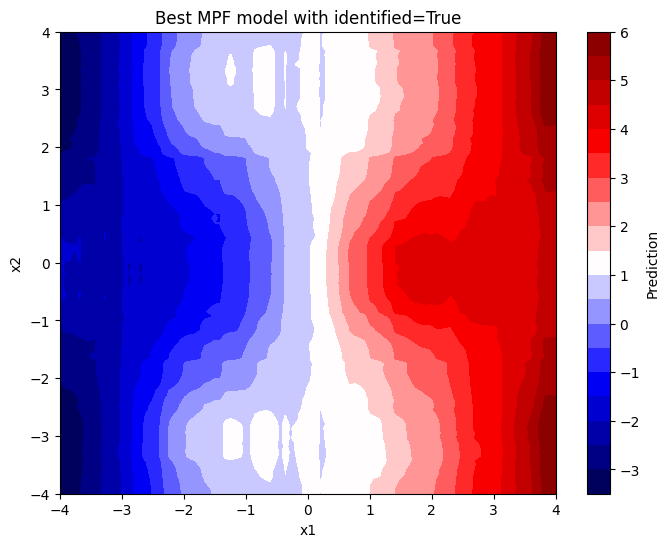

Test MSE for MPF with identified=True: 0.2670419313151614


In [4]:
# Plot the best MPF model with identified=True
plot_2d_model_predictions(lambda x: best_model_identified.predict(x), title="Best MPF model with identified=True")
test_preds = best_model_identified.predict(x_test)
test_error = np.mean((y_test - test_preds) ** 2)
print(f"Test MSE for MPF with identified=True: {test_error}")


In [3]:
[i for i in range(10)]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
mpf_tree_grid_rep = [mpf_py.TreeGrid(tgf.combined_tree_grid) for tgf in best_model_identified.tree_grid_families]

pred_function = lambda x: sum([tg.predict(x) for tg in mpf_tree_grid_rep])

plot_2d_model_predictions(pred_function, title="Identified MPF model predictions")
test_preds_identified = pred_function(x_test)
test_error_identified = np.mean((y_test - test_preds_identified) ** 2)
print(f"Test MSE for MPF with identified=True: {test_error_identified}")


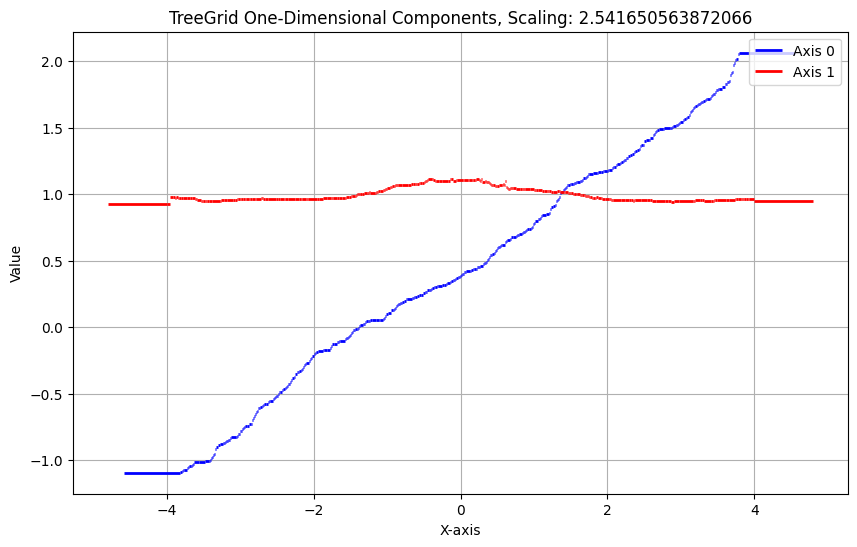

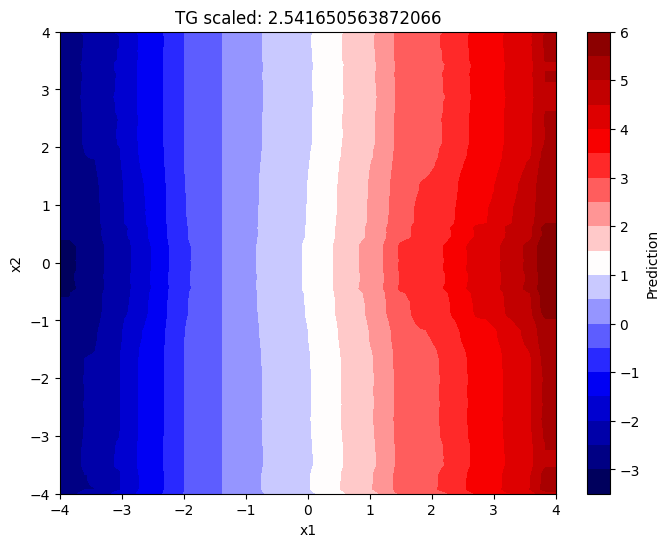

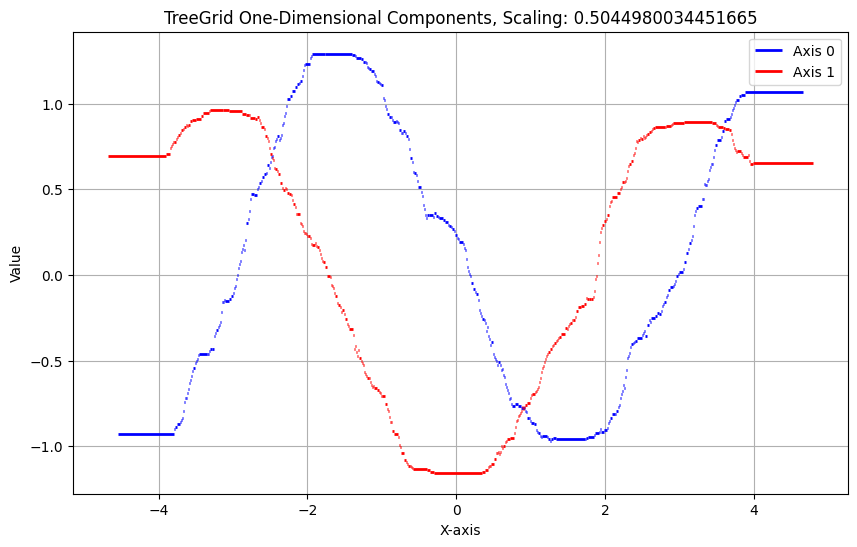

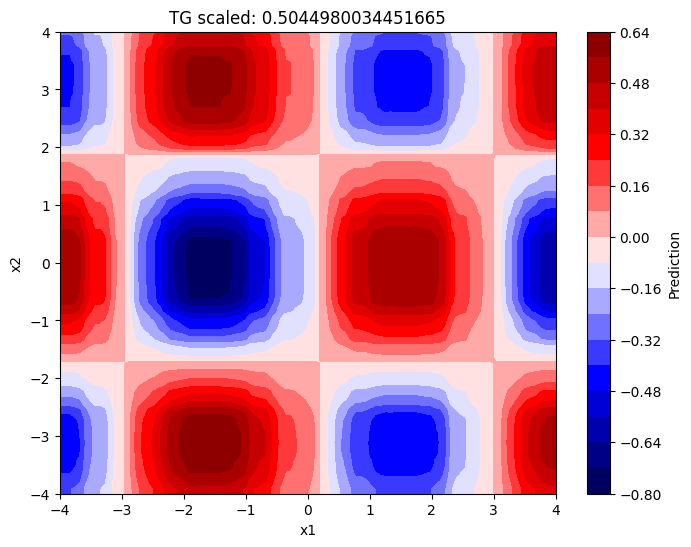

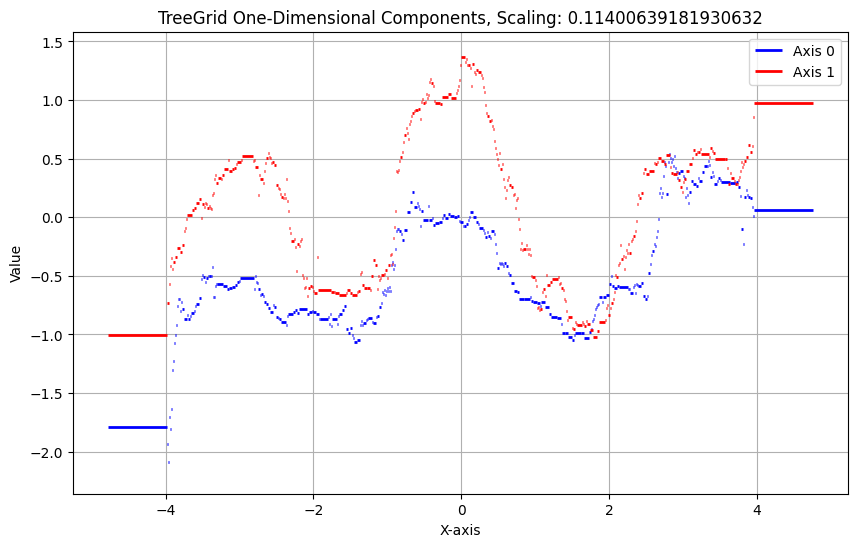

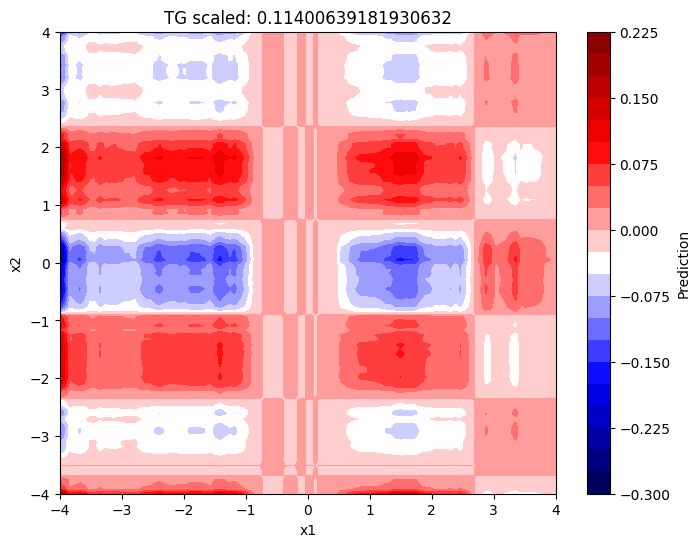

In [30]:
for tg in mpf_tree_grid_rep:
    tg.plot_components()
    plot_2d_model_predictions(lambda x: tg.predict(x), title=f"TG scaled: {tg.scaling}")


## Combining into a single TreeGrid

In [20]:
from collections import namedtuple

TreeGrid = namedtuple("TreeGrid", ["intervals", "grid_values", "splits"])

def geometric_mean(values):
    values = np.asarray(values)
    eps = 1e-12
    n = values.size
    # Count the number of negative values
    neg_count = np.sum(values < 0)
    # Compute the sum of logs of the absolute values (adding eps to avoid log(0))
    mean_log = np.sum(np.log(np.abs(values) + eps)) / n
    gmean = np.exp(mean_log)
    return -gmean if neg_count > n / 2 else gmean

def arithmetic_mean(values):
    return np.mean(values)

def combine_into_single_tree_grid(tree_grids, mean_method=geometric_mean):
    intervals = []
    grid_values = []
    splits = []

    axes = len(tree_grids[0].intervals)
    for i in range(axes):
        curr_intervals = []
        curr_grid_values = []

        combined = sum([tg.splits[i] for tg in tree_grids], [])
        curr_splits = np.sort(np.unique(combined))

        curr_intervals.append((float('-inf'), curr_splits[0]))
        for s in range(len(curr_splits)-1):
            curr_intervals.append((curr_splits[s], curr_splits[s+1]))
        curr_intervals.append((curr_splits[-1], float('inf')))

        for (a, b) in curr_intervals:
            values = []
            for tg in tree_grids:
                for j in range(len(tg.intervals[i])):
                    (a1, b1) = tg.intervals[i][j]
                    if a1 <= a and b <= b1:
                        values.append(tg.grid_values[i][j])
                        break
            combined_value = mean_method(values)
            curr_grid_values.append(combined_value)

        intervals.append(curr_intervals)
        grid_values.append(curr_grid_values)
        splits.append(curr_splits)

    return TreeGrid(intervals, grid_values, splits)


Now combine everything


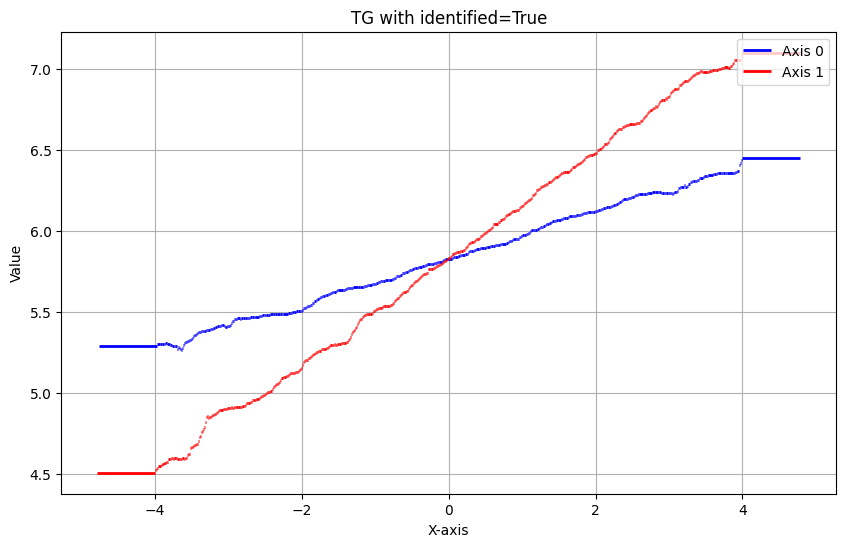

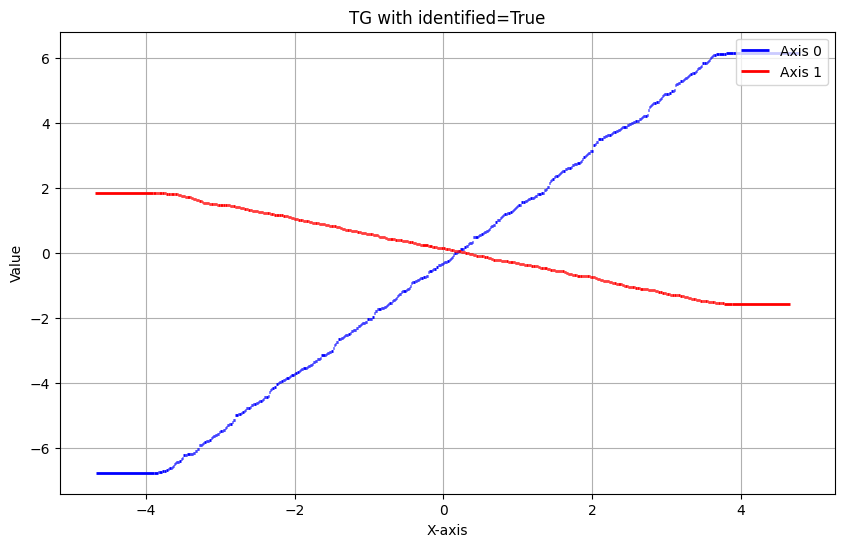

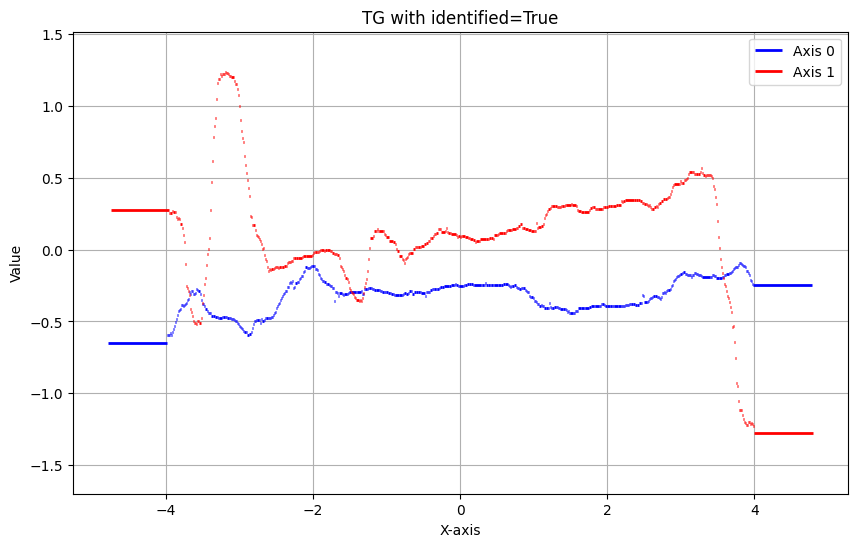

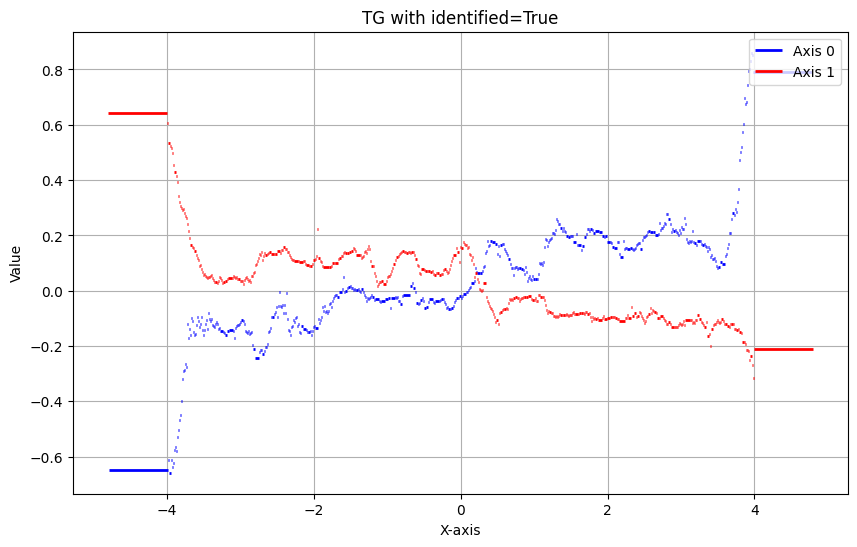

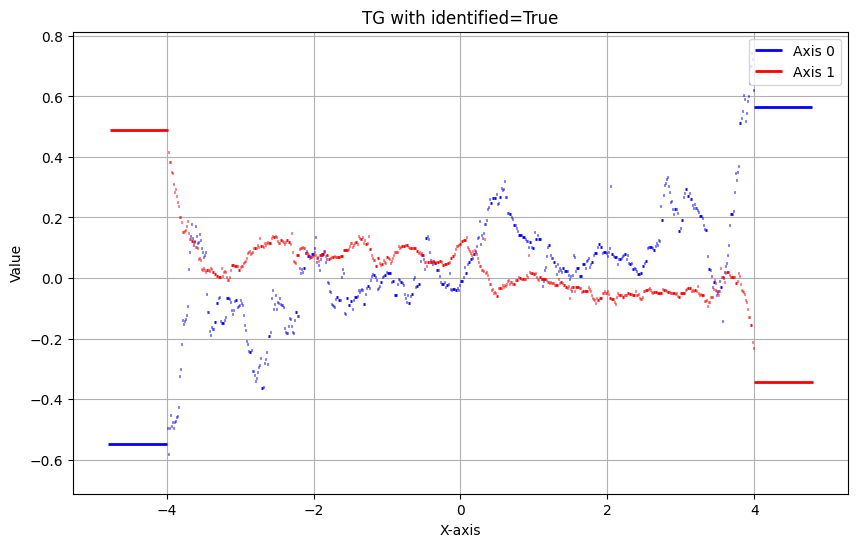

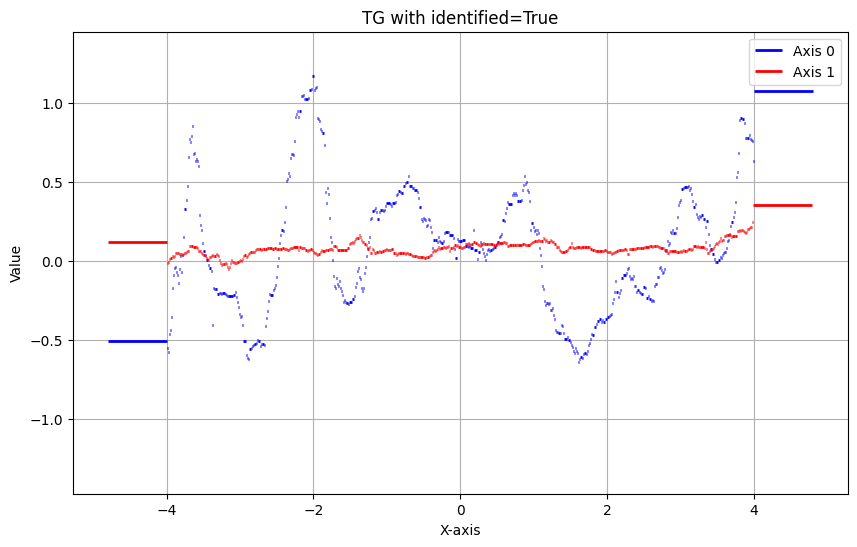

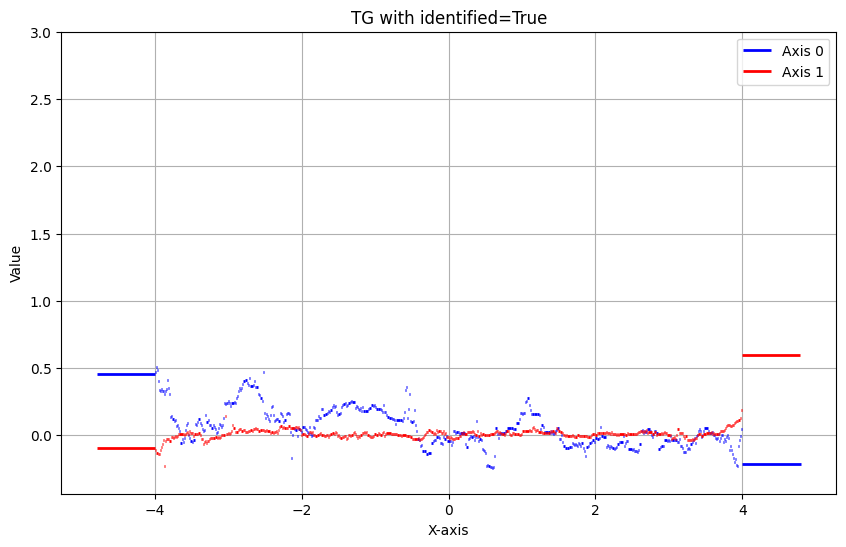

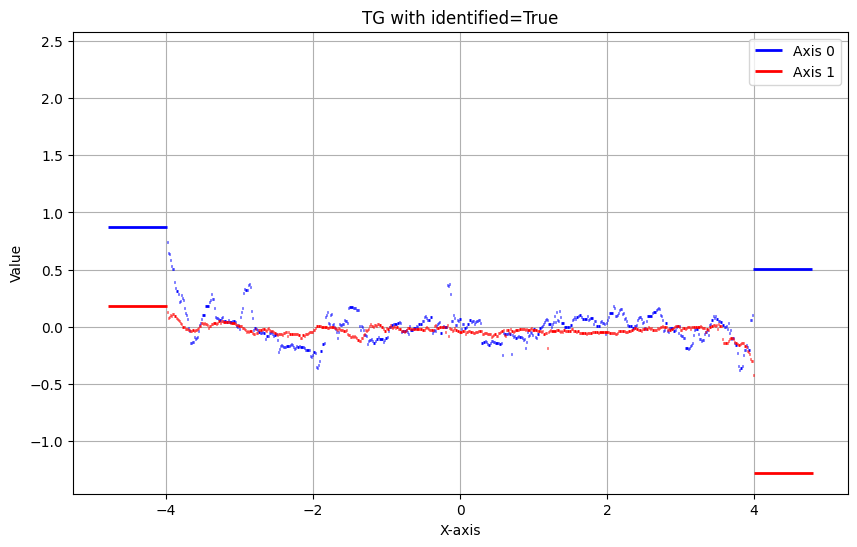

In [42]:

from utils import plot_intervals_with_values_all


for tgf in best_model.tree_grid_families:
    combined_tg = combine_into_single_tree_grid(tgf, arithmetic_mean)
    plot_intervals_with_values_all(combined_tg.intervals, combined_tg.grid_values, title="TG with identified=True")
